# 01 – Data Collection & Exploration

'''This notebook explores the pre-market stock data collected using `fetch_and_save_premarket.py`.

- Load the latest pre-market data  
- Visualize gap percentages  
- Begin identifying patterns in movers'''


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import os
import yfinance as yf
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# Load premarket data
df = pd.read_csv('../data/daily_report.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df

ticker  prev_close    open  gap_pct                  timestamp
0   NVDA      159.34  158.20    -0.72 2025-07-07 22:32:41.297468
1   TSLA      315.35  291.37    -7.60 2025-07-07 22:32:41.472511
2   AAPL      213.55  212.68    -0.41 2025-07-07 22:32:41.621568
3    AMD      137.91  136.56    -0.98 2025-07-07 22:32:41.758866
4   MSFT      498.84  497.38    -0.29 2025-07-07 22:32:41.943069

### What is a Gap?

''' A **gap** occurs when a stock opens significantly higher or lower than its previous day's closing price.  
This project uses `gap_pct` to detect such movements.

**Formula:** gap_pct = ((open - prev_close) / prev_close) * 100


- **Gap Up**: Bullish move → opens higher than it closed
- **Gap Down**: Bearish move → opens lower than it closed

We use this to find stocks likely to show momentum early in the trading day — ideal setups for options trades.

'''


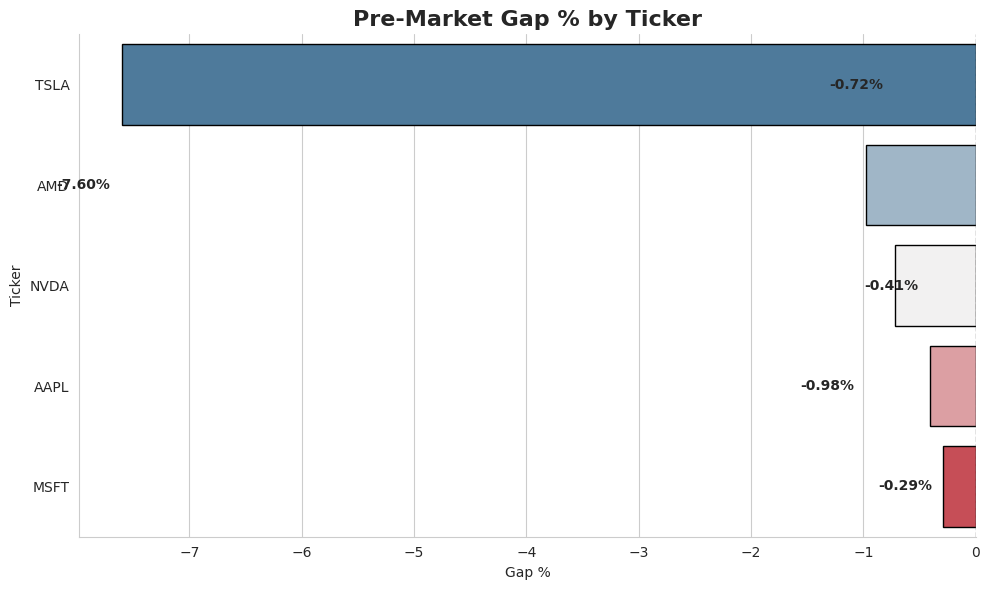

In [2]:
# Pre-Market Gap % Chart

# Sort by gap %
df_sorted = df.sort_values('gap_pct')

# Plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

barplot = sns.barplot(
    data=df_sorted,
    x='gap_pct',
    y='ticker',
    palette=sns.diverging_palette(240, 10, n=5),  # coolwarm custom
    edgecolor='black'
)

# Annotate bars with values
for i, row in df_sorted.iterrows():
    barplot.text(
        row['gap_pct'] + (0.1 if row['gap_pct'] > 0 else -0.1),
        i,
        f"{row['gap_pct']:.2f}%",
        va='center',
        ha='left' if row['gap_pct'] > 0 else 'right',
        fontsize=10,
        fontweight='bold'
    )

plt.title("Pre-Market Gap % by Ticker", fontsize=16, weight='bold')
plt.xlabel("Gap %")
plt.ylabel("Ticker")
plt.axvline(0, linestyle='--', color='gray', linewidth=1)
sns.despine()
plt.tight_layout()
plt.show()


In [3]:
# Ensure your API key is loaded
openai.api_key = os.getenv("OPENAI_API_KEY")

# Create the prompt dynamically from the sorted gap data
prompt = f"""
Generate a professional, 3–5 sentence financial market summary based on this pre-market gap data:

Ticker Gap %:
{df_sorted[['ticker', 'gap_pct']].to_string(index=False)}

Focus on:
- Biggest gainers or losers
- Market sentiment
- Any notable names (like TSLA, AAPL, NVDA)

Do not include things not in the data. Make it sound like a trader briefing another trader.
"""

# Use the new openai.ChatCompletion API (v1+)
from openai import OpenAI

client = OpenAI()

response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": "You are a professional financial analyst summarizing pre-market data."},
        {"role": "user", "content": prompt}
    ]
)

summary = response.choices[0].message.content
print(summary)

In our pre-market review, Tesla (TSLA) stands out as the sharpest decliner with a hefty -7.60% gap. This is followed distantly by AMD and NVDA, receding by -0.98% and -0.72% respectively. Tech giants Apple (AAPL) and Microsoft (MSFT) manifest minor gaps, each dipping below 0.5% - with AAPL at -0.41% and MSFT retreating by -0.29%. The overall pre-market scenario seems to be dominated by a bearish sentiment, particularly among notable tech names.


In [4]:
def get_prev_close_volume(ticker):
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(period="2d")
        if len(hist) >= 2:
            return int(hist["Volume"].iloc[-2])  # Previous full day's volume
        elif len(hist) == 1:
            return int(hist["Volume"].iloc[0])
        else:
            return None
    except Exception as e:
        print(f"Error fetching volume for {ticker}: {e}")
        return None

df["volume"] = df["ticker"].apply(get_prev_close_volume)


# Show result
df[["ticker", "gap_pct", "volume"]]

ticker  gap_pct     volume
0   NVDA    -0.72  143716100
1   TSLA    -7.60   58042300
2   AAPL    -0.41   34955800
3    AMD    -0.98   28646000
4   MSFT    -0.29   13984800

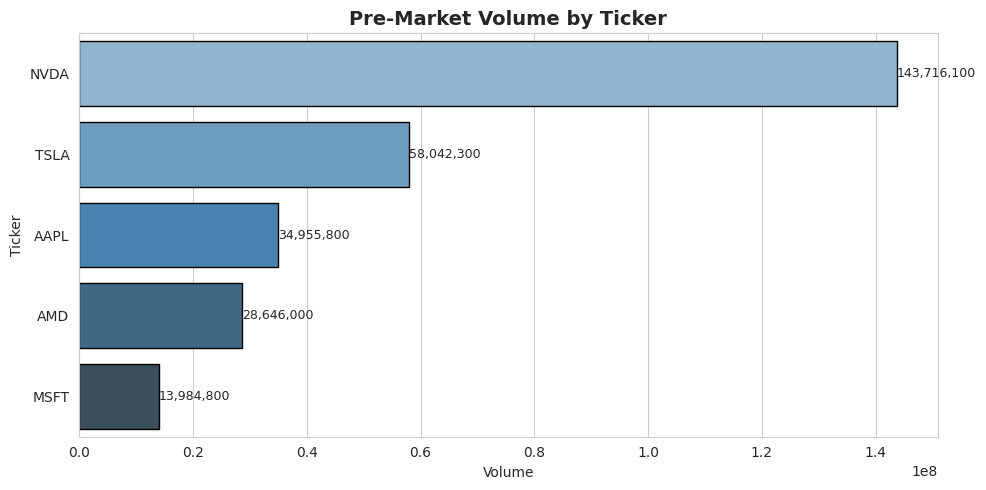

In [5]:
# Sort by volume
df_sorted_vol = df.sort_values("volume", ascending=False)

plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

barplot = sns.barplot(
    data=df_sorted_vol,
    x="volume",
    y="ticker",
    palette="Blues_d",
    edgecolor='black'
)

plt.title("Pre-Market Volume by Ticker", fontsize=14, weight="bold")
plt.xlabel("Volume")
plt.ylabel("Ticker")

# Add volume annotations
for i, row in df_sorted_vol.iterrows():
    barplot.text(
        row['volume'],
        i,
        f"{int(row['volume']):,}",
        va='center',
        ha='left',
        fontsize=9
    )

plt.tight_layout()
plt.show()

In [7]:
# Save the final filtered_df to CSV
df.to_csv("daily_report.csv", index=False)